# $l_1$--regularization
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

We want to minimize:
$$
\min_x \frac 1 2 ||Ax-b||^2 + \lambda  ||x||_1 =: F(x)=f(Ax)+g(x),
$$
where $A\in \R^{m\times n}$ is a matrix data, $b\in \R^m$ is a given observation, and $x\in \R^n$ is an unknown signal.

We can rewrite the problem above in a primal-dual form as follows:
$$
\min_x \max_y g(x)+(Ax,y)-f^*(y),
$$
where $f(x) = \frac 1 2 ||x-b||^2$, $f^*(y) = \frac 1 2 ||y||^2 + (b,y) = \frac 1 2 ||y+b||^2 -\frac{1}{2}||b||^2$ and $g(x) = \lambda ||x||_1$.

For the problem in a primal-dual form we apply primal-dual methods.

In [1]:
import matplotlib.pyplot as plt

from opt_operators import *
from methods.pd_algorithms import *
from methods.gr_pd_algorithms import *

import scipy.sparse.linalg as spr_LA


We construct our data in one of the following ways below. We will use a fixed random generator for all our data to make experiments reproducible.

In [2]:
gen = 100

In [3]:
n = 2000
m = 1000
s = 100
la = 0.1

np.random.seed(gen)
A = np.random.normal(0,1, (m,n))

np.random.seed(gen)
w = np.random.uniform(-10,10, n)

#w = np.random.normal(0,1, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

For the problem below we took $p = 0.5$ or $p = 0.9$

In [24]:
n = 2000
m = 1000
s = 10
la = 0.1

np.random.seed(gen)
B = np.random.normal(0,1, (m,n))
p = 0.9
A = np.zeros((m,n))
A[:,0] = B[:,0]/np.sqrt(1-p**2)
for j in np.arange(1,n):
    A[:,j] = p*A[:,j-1] + B[:,j]

np.random.seed(gen)
w = np.random.uniform(-10,10, n)
w[s:] = 0
np.random.seed(gen)
w = np.random.permutation(w)

Define $\nu$ and $b$

In [4]:
np.random.seed(gen)
nu = np.random.normal(0,0.1, m)
b = A.dot(w) + nu

Define all ingredients for primal-dual methods

In [5]:
def f_conj(y):
    return 0.5*(y+b).dot(y+b)

def g(x):
    return la*LA.norm(x,1)

def prox_g(x, rho):
    return prox_norm_1(x,la*rho)
    #return np.fmax(x, 0)

def prox_f_conj(y, rho):
    return (y - rho*b)/(1+rho)

def prox_f(y, rho):
    return (y + rho*b)/(1+rho)

# define energy 
def J(x,y,min_val):
    t = A.dot(x)-b
    return np.abs(0.5* t.dot(t) + la* LA.norm(x,1)-min_val)
# We need the following in order to apply accelerated primal-dual with f^* strongly convex.
def J1(y,x,min_val):
    return J(x,y,min_val)


#### for proximal gradient method and FISTA
def dh(x):
    return A.T.dot(A.dot(x)-b)

def F(x):
    return J(x,1)

Compute matrix norm of operator $A$. This may be long if you consider large-scale problems.

In [6]:
L = np.sqrt(np.max(LA.eigh(A.dot(A.T))[0]))

# starting points
x0 = np.zeros(n)
y0 = -b

# step size for PDA and GRPDA
tau = 1./L
sigma = 1./L
phi = 1.618


sqrt_phi = np.sqrt(phi)
tau1 = tau*sqrt_phi      # for GRPDA
sigma1 = sigma*sqrt_phi    # for GRPDA


# step size for PGM and FISTA
alpha = 1./L**2

# generate initial step size randomly
#tau0 = np.sqrt(1.618)*np.sqrt(m)/LA.norm(A)
gen = 100  # random generator
np.random.seed(gen)
prec=1e-10
beta = 400
y1 = y0 + np.random.random(y0.shape) * prec
# need to fix division in case of zero in the denominator
m = LA.norm(y1 - y0) / LA.norm(A.T.dot(y1 - y0))
tau0 = np.sqrt(1/beta) * m   # for PDA-L 
tau1 = np.sqrt(1.5/beta) * m     # for  GRPDA-L
tau2 = np.sqrt(1.5) * m    # for AGRPDA-L

Get an approximation of the optimal value $F^*$

In [7]:
T = 0
# number of iterations
N = 20000
ans01 = pd_accelerated_Golden_linesearch(J1, prox_f_conj, prox_g,  -A.T, y0, x0, tau2, 1, 0.01, 0, numb_iter=N, tol=T)
ans02 = pd_linesearch_acceler_dual_is_square_norm(J, prox_g, b, A,  x0, y0, tau0, 1, 0.1,0, numb_iter=N)
min_val = min(ans01[0]+ans02[1])
print(min_val)

Accelerated Golden-Ratio Primal-dual method with linesearch does not terminate after 77.03 seconds
Number of linesearch: 5910
----- Accelerated primal-dual method with  linesearch for dual f^*(y)=0.5*||y-b||^2-----
Time execution: 58.19
Number of linesearch: 19678
51.04256214774084


In [8]:
T = 1e-12
N = 80000

#ans1 = pd_Golden(J, prox_g, prox_f_conj, A, x0, y0, 0.05*sigma1, 20*tau1,phi, min_val, numb_iter=N,tol=T)
ans2 = pd_linesearch_dual_is_square_norm(J, prox_g, -b, A, x0, y0, tau0, 1./beta, min_val, numb_iter=N, tol=T)
ans3 = pd_Golden_linesearch_dual_is_square_norm(J, prox_g, -b, A, x0, y0, tau1, 1./beta, min_val, numb_iter=N, tol=T)
ans4 = pd_accelerated_Golden_linesearch(J1, prox_f_conj, prox_g,  -A.T, y0, x0, tau2, 1, 0.01, min_val, numb_iter=N, tol=T)


Iter: 11177
----- Primal-dual method with  linesearch. f^*(y)=0.5*||y-b||^2------
Time execution: 29.08
Number of linesearch: 11020
Iter: 9734
-----Golden-Ratio Primal-dual method with linesearch_dual_is_square_norm-----
Time execution: 24.94
Number of linesearch: 2859
Iter: 3512
-----Accelerated Golden-Ratio Primal-dual method with linesearch-----
Time execution: 13.34
Number of linesearch: 1038


To see the plots of residual $f(Ax)+g(x) - f(Ax^*)-g(x^*)$. For simplicity, we just set $f(Ax^*)+g(x^*)$ as the smallest number among all energy values for all methods during all iterations. Alternatively, you can increase number of iterations to obtain even better ground truth solution.

Nice plots as in the paper:

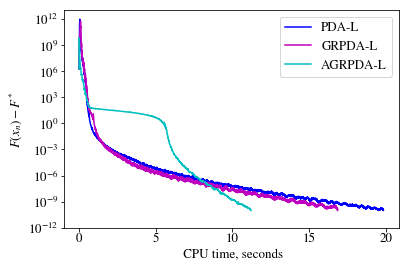

In [11]:
import matplotlib as mpl
mpl.rc('lines', linewidth=1.5)
mpl.rcParams.update(
    {'font.size': 13, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 2

#plt.plot(ans1[-1], ans1[0], 'g',label = 'GRPDA')

plt.plot(ans2[0],ans2[1], 'b', label = 'PDA-L')
plt.plot(ans3[-2],ans3[0], 'm',label = 'GRPDA-L')
plt.plot(ans4[-2],ans4[0], 'c',label = 'AGRPDA-L')

plt.yscale('log')
#plt.xscale('log')
plt.xlabel(u' CPU time, seconds')
plt.ylabel('$F(x_n)-F^*$')
plt.ylim([1e-12,1e+13])
plt.legend()
#plt.savefig('figures/LR1-time0.pdf')
plt.show()